# Cohort Project 2021: Trapped Ions

This notebook provides a solution for the "Trapped Ions" project (week 1) for the CDL cohort project of 2021. See the original Github repositiory [here](https://github.com/CDL-Quantum/CohortProject_2021).

## Instructions
This notebook has been designed to be used in a google colab environment which runs jupyter notebooks. Please follow the following instructions to set the colab kernel to Julia.
1. Copy this notebook and upload it into a google colab.
1. Execute the following cell to install Julia, IJulia and other packages. This takes a couple of minutes.
2. **Reload** this page and continue to the next section.

_Notes_:
* The setup for Julia was adapted from the [Julia template file](https://colab.research.google.com/github/ageron/julia_notebooks/blob/master/Julia_Colab_Notebook_Template.ipynb) for google colab. If you have any issues setting up, please reference that.
* If you have issues or if your runtime is disconnected, please try a factory reset on the runtime and repeat steps 2 and 3 above.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.0"
JULIA_PACKAGES="IJulia BenchmarkTools Printf Plots PastaQ LinearAlgebra ITensors"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Success! Please reload this page and jump to the next section."
fi

Installing Julia 1.6.0 on the current Colab Runtime...
2021-07-08 02:48:17 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.6/julia-1.6.0-linux-x86_64.tar.gz [112838927/112838927] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing Julia package Printf...
Installing Julia package Plots...
Installing Julia package PastaQ...
Installing Julia package LinearAlgebra...
Installing Julia package ITensors...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.6

Success! Please reload this page and jump to the next section.


Defines the libraries that we want to use

In [123]:
using PastaQ
using LinearAlgebra
using ITensors
using Plots
using Printf
using Random

Define the M and R gates (adapted from the [sample script](https://github.com/CDL-Quantum/CohortProject_2021/blob/main/Week1_Trapped_Ions/run_random_circuit.jl)).

In [124]:
function PastaQ.gate(::GateName"R"; theta::Real, phi::Real)
    [
        cos(theta/2)    (-im * exp(-im * phi) * sin(theta/2))
        (-im * exp(im * phi) * sin(theta/2))     cos(theta/2)
    ]
end

function PastaQ.gate(::GateName"M"; Theta::Real)
    [
        cos(Theta)    0    0    (-im * sin(Theta))
        0    cos(Theta)    (-im * sin(Theta))    0
        0    (-im * sin(Theta))    cos(Theta)    0
        (-im * sin(Theta))    0    0    cos(Theta)
    ]
end

Define another gate enabling a bit flip (for task 2)

In [125]:
function PastaQ.gate(::GateName"E")
    [
        0    1
        1    0
    ]
end

Define the helper functions that we need.

In [126]:
# Generates a "state" vector where 1=>"Up" and 0=>"Dn"
generate_state(vector) = [i == 1 ? "Up" : "Dn" for i=vector]

# Generates permutations i.e. [0, 0], [0, 1], [1, 0], [1, 1]
generate_permutations(n) = vec(map(collect, Iterators.product(ntuple(_ -> [0, 1], n)...)))

# Constructs bit strings as an array of MPSs given the number of qubits N
function construct_bit_strings(N)
    # Construct the basis vectors
    x_vectors = generate_permutations(N)

    # Convert the basis vectors into MPSs
    sites = siteinds("S=1/2",N)
    states = [generate_state(basis_vector) for basis_vector=x_vectors]
    x = [productMPS(sites, state) for state=states]
end

# Generates coefficients of the basis vectors x (MPS array) and psi (MPS)
generate_coefficients(x, psi) = [dot(mps, psi) for mps=x]

# Computes the probabilities for each coef by computing the square norm of each coefficient
get_bit_string_probabilities(coefficients) = [norm(coefficient)^2 for coefficient=coefficients]

get_bit_string_probabilities (generic function with 1 method)

Add the adapted function from the [sample script](https://github.com/CDL-Quantum/CohortProject_2021/blob/main/Week1_Trapped_Ions/run_random_circuit.jl) which was previously called `run`.
- Has an extra paramater `is_bit_flip_error_enabled` which is boolean indicating if a bit flip error gate is randomly applied (this paramater is used for task 2).


In [164]:
# Constructs psi as a MPS
function construct_psi(N, depth, is_bit_flip_error_enabled)
    # Random circuit.
    gates = Vector{Tuple}[]

    # If is_bit_flip_error_enabled is true, we add a bit flip gate at a depth of idx_bit_flip_error
    idx_bit_flip_error = is_bit_flip_error_enabled ? rand(MersenneTwister(), 1: depth) : -1 # The use of MersenneTwister() ensures idx_bit_flip_error is random despite any seed

    for i in 1:depth
        one_qubit_layer = Tuple[]
        two_qubit_layer = Tuple[]

        for j in 1:N
            gate = ("R", j, (theta=2pi*rand(), phi=2pi*rand()))
            push!(one_qubit_layer, gate)
        end

        # Alternate start qubit for pairs.
        idx_first = i % 2 + 1

        for j in idx_first:2:(N-1)
            gate = ("M", (j, j+1), (Theta=2pi*rand(),))
            push!(two_qubit_layer, gate)
        end

        push!(gates, one_qubit_layer)
        push!(gates, two_qubit_layer)

        if (idx_bit_flip_error == i)
          # Adds the bit flip gate
          @printf "Adding bit flip at index %d\n" i
          err_qubit_layer = Tuple[]
          for j in 1:N 
              gate = ("E", j)
              push!(err_qubit_layer, gate)
          end
          push!(gates, err_qubit_layer)
        end
    end

    psi = runcircuit(N, gates)
end

construct_psi (generic function with 2 methods)

**The main function that puts everything together**

1.   Initializes the random seed
2.   First we construct the basis vectors (bit strings) as MPSs
3.   Next generate psi as an MPS
4.   Computes the probabilities for each bit string
5.   Generates a nice speckle plot of the probabilities



In [165]:
# Function to run the experiments end-to-end and generate speckle patterns
function main(N, depth, is_bit_flip_error_enabled = false)
    # Sets the seed
    Random.seed!(1234)

    # Constructs the bit strings
    x = construct_bit_strings(N)

    # Generates psi
    psi = construct_psi(N, depth, is_bit_flip_error_enabled)

    # Gets each coefficient 
    coefficients = generate_coefficients(x, psi)

    # Computes the probability
    probabilities = get_bit_string_probabilities(coefficients)

    # Generate the "speckle pattern"
    title = @sprintf("Bit string probabilities for %d qubits and depth of %d", N, depth)
    display(plot(probabilities, markersize = probabilities, title = title))
end

main (generic function with 2 methods)

## Solution for task 1

We test permutations of number of qubits 4, 8 and 12 and depths 1, 5 and 10. Bit string probabilities are plotted below.

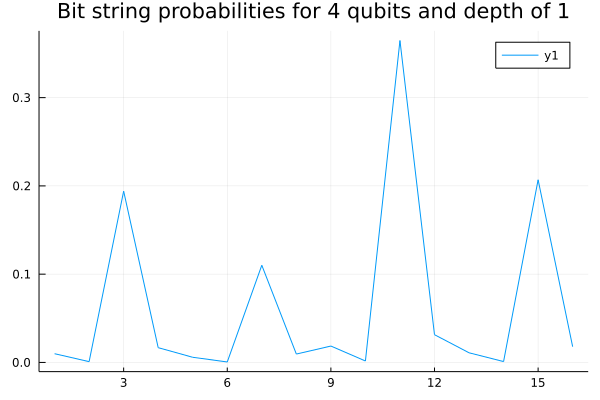

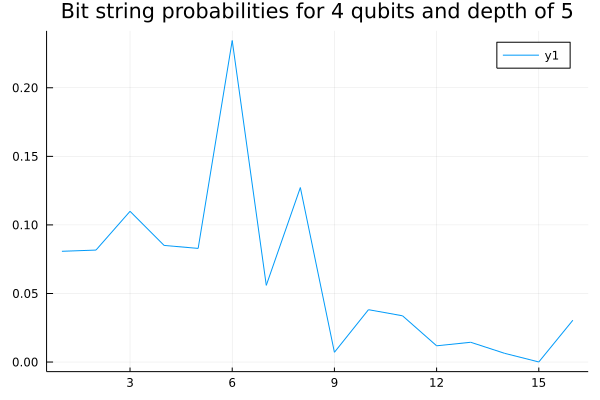

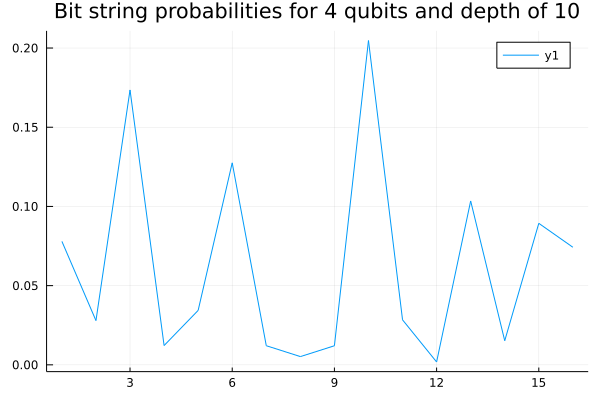

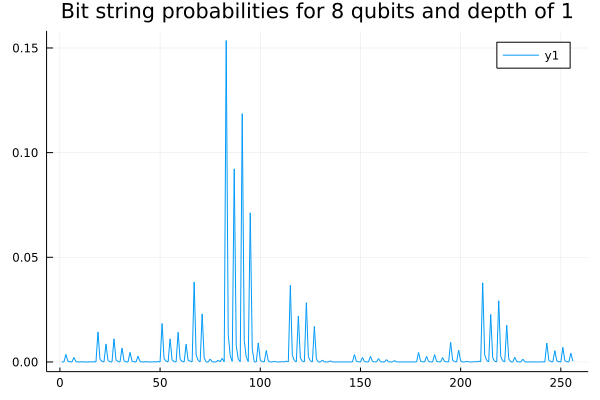

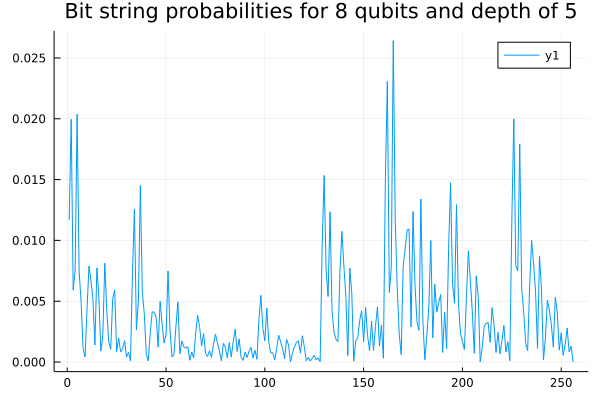

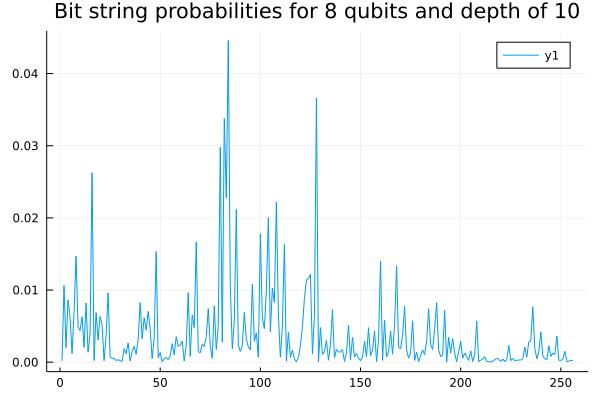

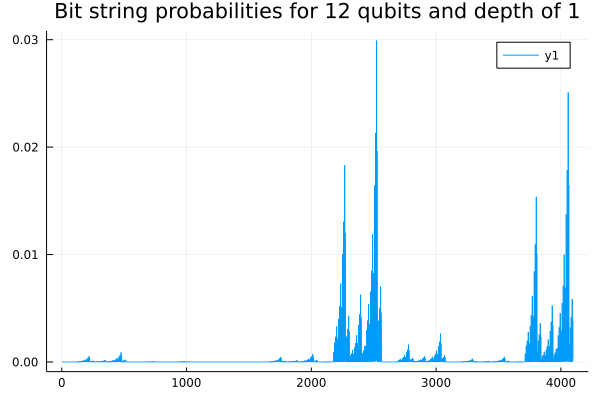

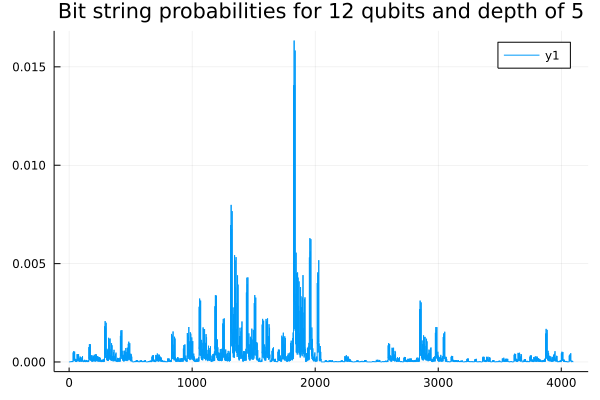

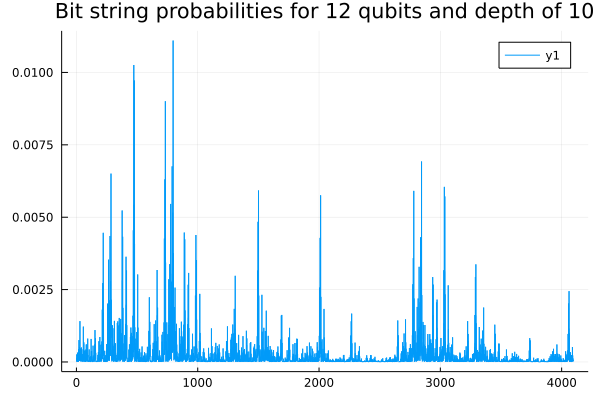

In [166]:
# This block contains the code to solve task 1

Ns = [4, 8, 12]
depths = [1, 5, 10]
for N in Ns
  for depth in depths
    main(N, depth)
  end
end



## Solution for task 2
We observe very different probability distributions when enabling random bit flips. Here we show 9 runs of the same random circuit but with random bit flips enabled.

Notes:
- Sometimes, you might see the same distribution if the bit flip happens to be at the same location in the circuit

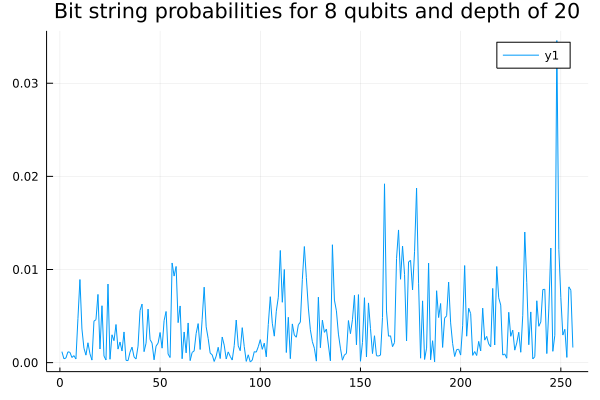

Adding bit flip at index 4
Adding bit flip at index 3


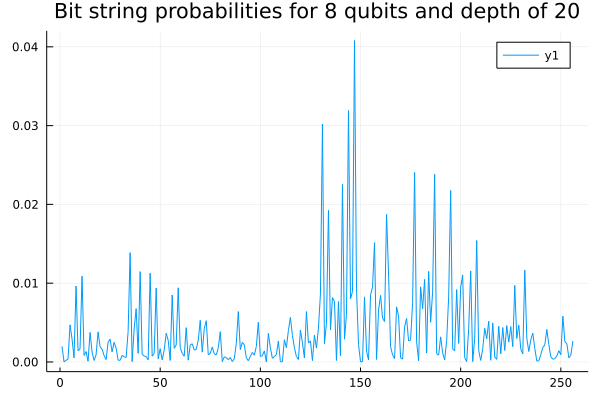

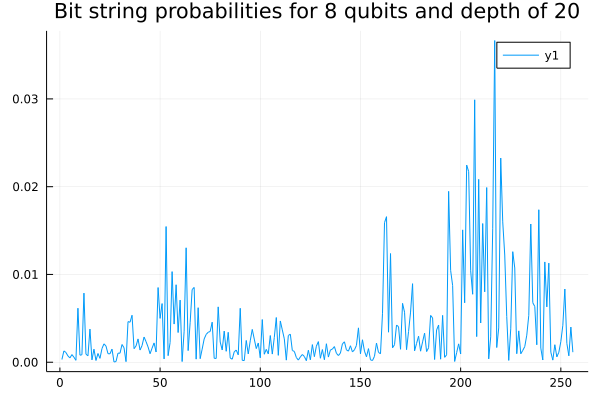

Adding bit flip at index 6
Adding bit flip at index 8


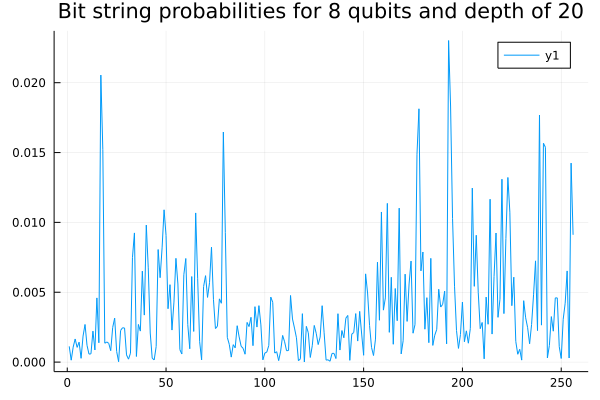

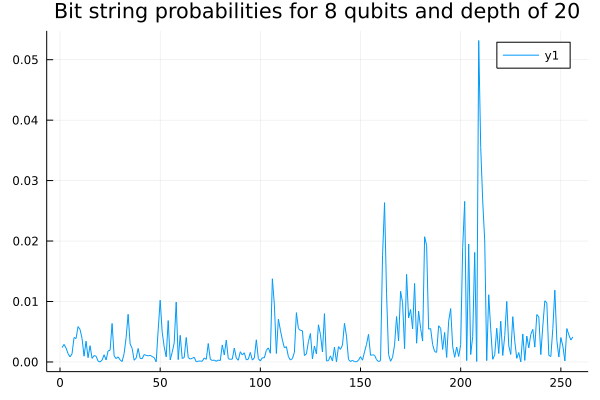

Adding bit flip at index 5
Adding bit flip at index 11


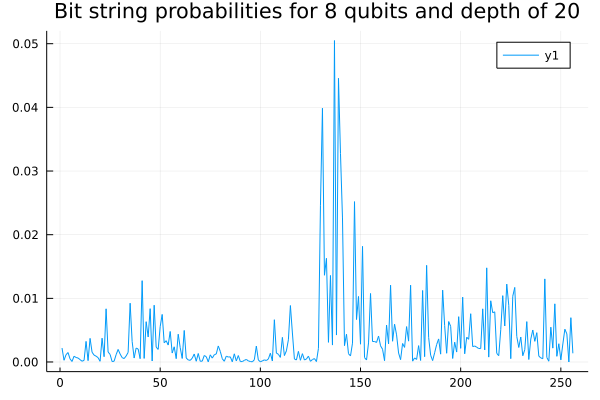

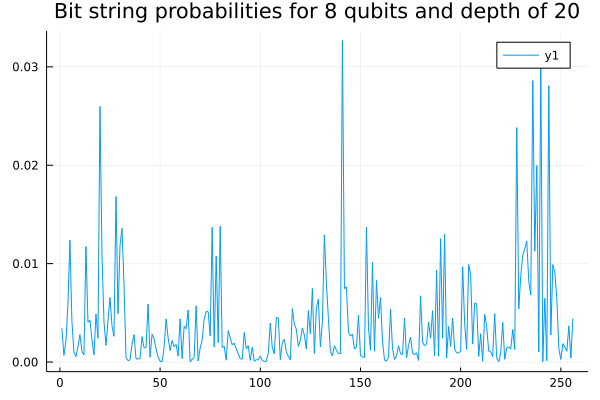

Adding bit flip at index 10
Adding bit flip at index 2


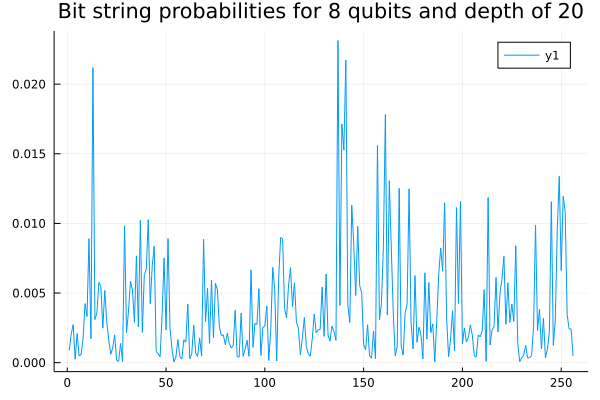

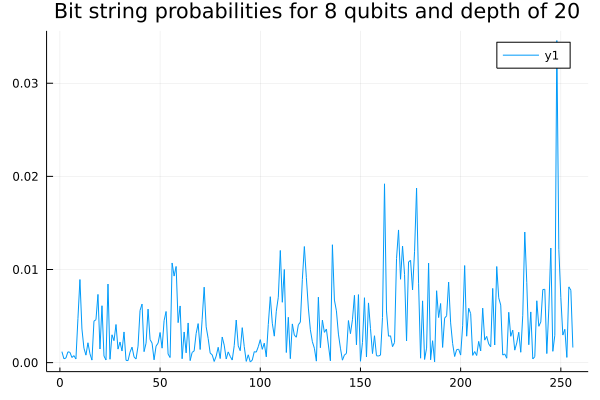

Adding bit flip at index 4


In [168]:
n_iterations = 9 # Number of times to run the circuit
N = 8 # Number of qubits
depth = 20 # Depth of the circuit

for _ in 1:n_iterations
    # Runs main with the bit flip error toggled on
    main(N, depth, true)
end